In [1]:
# --- Cell 1: Setup and Installation ---

print("Installing required libraries for CLIP model...")
# Using -q for a quieter installation of libraries.
!pip install -q transformers torch accelerate pandas
print("--> Libraries installed successfully.")

Installing required libraries for CLIP model...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00:00:0100:01
--> Libraries installed successfully.


In [2]:
# --- Cell 2: Imports and Model Loading ---

print("Importing libraries and loading the CLIP model...")
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# The specific CLIP model we will use.
MODEL_NAME = "openai/clip-vit-base-patch32"

try:
    # Load the pre-trained model from Hugging Face's model hub
    model = CLIPModel.from_pretrained(MODEL_NAME)
    # Load the processor, which handles preparing images and text for the model
    processor = CLIPProcessor.from_pretrained(MODEL_NAME)
    print("--> CLIP model and processor loaded successfully.")
except Exception as e:
    print(f"!!! ERROR loading CLIP model: {e}")
    print("!!! Please ensure your Kaggle notebook has internet access enabled in the settings.")
    raise # Stop the script if the model can't be loaded

Importing libraries and loading the CLIP model...


2025-07-19 12:10:57.138409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752927057.361553      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752927057.427098      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

--> CLIP model and processor loaded successfully.


In [3]:
# --- Cell 3: Define the Style Classification Function ---

print("Defining the style classification function...")

def classify_style(image, style_categories, model, processor):
    """
    Classifies an image into one of the provided style categories using CLIP.
    """
    # Prepare the inputs for the CLIP model. The processor handles both image and text.
    inputs = processor(
        text=style_categories, 
        images=image, 
        return_tensors="pt", # Return PyTorch tensors
        padding=True
    )
    
    # Get the model's predictions. We use torch.no_grad() for efficiency as we are not training.
    with torch.no_grad():
        outputs = model(**inputs)
    
    # The logits_per_image represents the raw similarity scores between the image and each text prompt.
    logits_per_image = outputs.logits_per_image 
    # We convert these scores to probabilities using the softmax function for better interpretability.
    probs = logits_per_image.softmax(dim=1)
    
    # Get the highest probability and its corresponding index from the list of categories.
    best_prob, best_idx = torch.max(probs, dim=1)
    
    # Return the best matching style label and its confidence score.
    return style_categories[best_idx.item()], best_prob.item()

print("--> Style classification function is ready.")

Defining the style classification function...
--> Style classification function is ready.


Defined Style Categories:
- a casual t-shirt or everyday top
- a formal business blouse or professional shirt
- comfortable and loose-fitting maternity wear
- a sporty activewear top or athletic jersey
- an elegant evening gown or glamorous party dress
- a professional business suit or formal blazer
- a rugged outdoor jacket or functional workwear
- bohemian or festival style clothing

--- Testing the classifier on 5 sample images ---


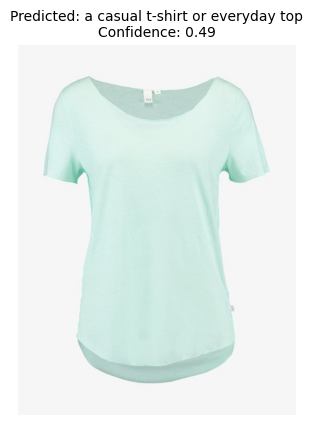

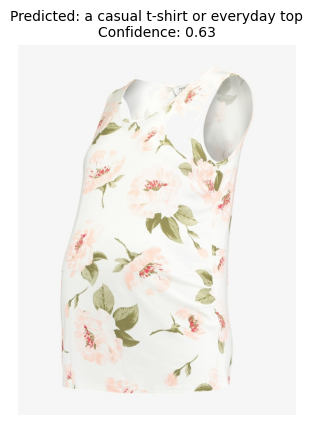

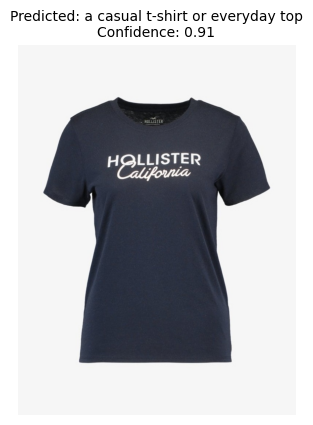

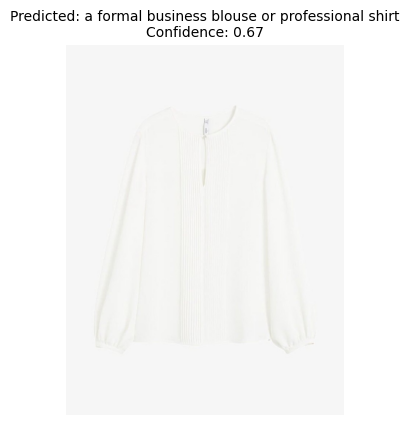

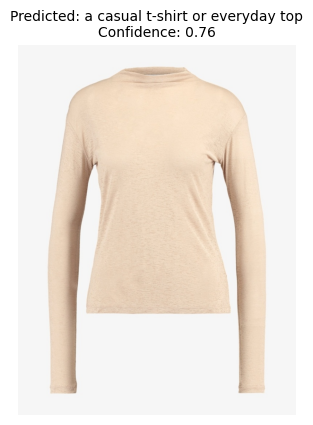

In [4]:
# --- Cell 4: Define Your Styles and Test the Classifier ---

# --- YOU CAN CUSTOMIZE THIS LIST WITH ANY STYLES YOU WANT! ---
# Using descriptive phrases often works better with CLIP than single words.
STYLE_CATEGORIES = [
    "a casual t-shirt or everyday top",
    "a formal business blouse or professional shirt",
    "comfortable and loose-fitting maternity wear",
    "a sporty activewear top or athletic jersey",
    "an elegant evening gown or glamorous party dress",
    "a professional business suit or formal blazer",
    "a rugged outdoor jacket or functional workwear",
    "bohemian or festival style clothing"
]

print("Defined Style Categories:")
for style in STYLE_CATEGORIES:
    print(f"- {style}")

# --- Test on a few sample images from your dataset ---
CLOTH_DATABASE_PATH = '/kaggle/input/clothestry/clothes_tryon_dataset/train/cloth'
try:
    sample_filenames = [os.path.join(CLOTH_DATABASE_PATH, f) for f in os.listdir(CLOTH_DATABASE_PATH)[:5]]
except FileNotFoundError:
    print(f"\n!!! ERROR: Could not find the cloth database at {CLOTH_DATABASE_PATH}")
    sample_filenames = []

print("\n--- Testing the classifier on 5 sample images ---")
for image_path in sample_filenames:
    try:
        image = Image.open(image_path)
        predicted_style, confidence = classify_style(image, STYLE_CATEGORIES, model, processor)
        
        # Display the image and its predicted style
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_style}\nConfidence: {confidence:.2f}", fontsize=10)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Could not process {image_path}: {e}")

In [5]:
# --- Cell 5: Create a "Style Profile" for Your Entire Dataset ---

print("Starting style classification for the entire dataset...")
print("(This may take a while depending on the number of images and GPU availability)")

# Define paths and check for existence
CLOTH_DATABASE_PATH = '/kaggle/input/clothestry/clothes_tryon_dataset/train/cloth'
OUTPUT_PATH = '/kaggle/working/'
if not os.path.exists(CLOTH_DATABASE_PATH):
    raise SystemExit(f"!!! FATAL ERROR: Dataset path not found at '{CLOTH_DATABASE_PATH}'")

# Get all the clothing filenames
all_cloth_files = [os.path.join(CLOTH_DATABASE_PATH, f) for f in sorted(os.listdir(CLOTH_DATABASE_PATH))]

results = []
# Loop through all files with a tqdm progress bar for visual feedback
for image_path in tqdm(all_cloth_files, desc="Classifying All Image Styles"):
    try:
        image = Image.open(image_path)
        style, confidence = classify_style(image, STYLE_CATEGORIES, model, processor)
        results.append({
            "filename": os.path.basename(image_path),
            "style_category": style,
            "confidence_score": confidence
        })
    except Exception as e:
        print(f"Warning: Could not process {image_path}. Error: {e}")
        results.append({
            "filename": os.path.basename(image_path),
            "style_category": "Processing_Error",
            "confidence_score": 0.0
        })

# Create a Pandas DataFrame from the results for easy analysis and saving
style_df = pd.DataFrame(results)

# Save the style profile to a CSV file in the output directory
output_csv_path = os.path.join(OUTPUT_PATH, 'cloth_style_profile.csv')
style_df.to_csv(output_csv_path, index=False)

print("\n\n--- Style Classification Complete! ---")
print(f"Results for all {len(style_df)} items have been saved to: '{output_csv_path}'")

# --- Display a summary of the results ---
print("\nFirst 10 rows of the generated style profile:")
display(style_df.head(10))

print("\nDistribution of styles across the entire dataset:")
# Use display() for better formatting of the DataFrame in notebooks
display(style_df['style_category'].value_counts())

print("\n--- SCRIPT FINISHED ---")

Starting style classification for the entire dataset...
(This may take a while depending on the number of images and GPU availability)


Classifying All Image Styles: 100%|██████████| 11647/11647 [35:42<00:00,  5.44it/s]




--- Style Classification Complete! ---
Results for all 11647 items have been saved to: '/kaggle/working/cloth_style_profile.csv'

First 10 rows of the generated style profile:


,filename,style_category,confidence_score
0,00000_00.jpg,a casual t-shirt or everyday top,0.835612
1,00001_00.jpg,a sporty activewear top or athletic jersey,0.646642
2,00002_00.jpg,a sporty activewear top or athletic jersey,0.972086
3,00003_00.jpg,a casual t-shirt or everyday top,0.811881
4,00005_00.jpg,a casual t-shirt or everyday top,0.794946
5,00007_00.jpg,a sporty activewear top or athletic jersey,0.832887
6,00009_00.jpg,a sporty activewear top or athletic jersey,0.987794
7,00010_00.jpg,a casual t-shirt or everyday top,0.793759
8,00011_00.jpg,a sporty activewear top or athletic jersey,0.967616
9,00012_00.jpg,a casual t-shirt or everyday top,0.618004



Distribution of styles across the entire dataset:


style_category
a sporty activewear top or athletic jersey          5143
a casual t-shirt or everyday top                    4964
a formal business blouse or professional shirt       641
comfortable and loose-fitting maternity wear         522
an elegant evening gown or glamorous party dress     282
bohemian or festival style clothing                   72
a rugged outdoor jacket or functional workwear        20
a professional business suit or formal blazer          3
Name: count, dtype: int64


--- SCRIPT FINISHED ---
